In [41]:
import numpy as np
from PIL import Image
import cv2

def split_into_panels(image, num_panels=6):
    width, height = image.size
    panel_width = width // num_panels
    panels = [image.crop((i * panel_width, 0, (i + 1) * panel_width, height)) for i in range(num_panels)]
    return panels

def crop_bottoms(panels, num_pixels=20):
    cropped_panels = [panel.crop((0, 0, panel.width, panel.height - num_pixels)) for panel in panels]
    return cropped_panels

def detect_horizon_tilt(panel):
    # Assuming you have already implemented the function detect_horizon_line from the previous code
    horizon_tilt = detect_horizon_line(panel)
    return horizon_tilt

def avg_color_above_horizon(panel, horizon_tilt):
    panel_array = np.array(panel.rotate(horizon_tilt))
    height = panel_array.shape[0] // 2
    sky_array = panel_array[:height]
    avg_sky_color = np.mean(sky_array, axis=(0, 1))
    return avg_sky_color

def avg_color_below_horizon(panel, horizon_tilt):
    panel_array = np.array(panel.rotate(horizon_tilt))
    height = panel_array.shape[0] // 2
    ocean_array = panel_array[height:]
    avg_ocean_color = np.mean(ocean_array, axis=(0, 1))
    return avg_ocean_color

def detect_horizon_line(img):
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use a Gaussian blur to reduce noise before edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    
    # Increase the threshold for HoughLinesP to reduce false positives
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 150, minLineLength=100, maxLineGap=20)
    
    if lines is None:
        return 0

    try:
        # Select the line closest to the horizontal orientation
        closest_horizontal_line = min(lines, key=lambda line: abs(np.arctan2(line[0][3] - line[0][1], line[0][2] - line[0][0])))
        x1, y1, x2, y2 = closest_horizontal_line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        return angle
    except Exception as e:
        print(f"Error: {e}")
        return 0

def process_panoramic_image(panoramic_image):
    panels = split_into_panels(panoramic_image)
    cropped_panels = crop_bottoms(panels)

    horizon_tilts = [detect_horizon_tilt(panel) for panel in cropped_panels]
    avg_sky_colors = [avg_color_above_horizon(panel, tilt) for panel, tilt in zip(cropped_panels, horizon_tilts)]
    avg_ocean_colors = [avg_color_below_horizon(panel, tilt) for panel, tilt in zip(cropped_panels, horizon_tilts)]

    return horizon_tilts, avg_sky_colors, avg_ocean_colors


In [46]:
!pip install segmentation_models_pytorch

  Using cached segmentation_models_pytorch-0.3.2-py3-none-any.whl (106 kB)
  Using cached timm-0.6.12-py3-none-any.whl (549 kB)
  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached pretrainedmodels-0.7.4.tar.gz (58 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.2 MB/s eta 0:00:00a 0:00:01
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 31.5 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=f8389525513e03a99395d2a3cfc44901eabe3505e60ce78c81d21037f50ca998
  Stored in directory: /Users/grahamwaters/Library/Caches/pip/wheels/13/d7/76/138efaee4cf27c8ac4837ee842a39f6574342e7038694cc409
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=046260124ab6d5a284d95beee96c3c962

In [47]:
import cv2
import torch
import numpy as np
from PIL import Image
import segmentation_models_pytorch as smp

def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0)

def postprocess_segmentation_mask(mask):
    mask = mask.squeeze().detach().numpy()
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)
    return np.uint8(mask > 0.5)

def detect_horizon_line(img, model):
    img_tensor = preprocess_image(img)
    output = model(img_tensor)
    mask = postprocess_segmentation_mask(output)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    x1, y1, x2, y2 = cv2.boundingRect(largest_contour)
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    return angle

# Load your pre-trained U-Net model
model = torch.load('

# Make sure the model is in evaluation mode
model.eval()

# Test the function with an example image
img = Image.open("W44A_2023_05_07_1710.jpg")
angle = detect_horizon_line(img, model)
print(angle)


/Users/grahamwaters/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/grahamwaters/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <3EF8D74C-9F11-3C9E-85DB-9E76BCCBE7A0> /Users/grahamwaters/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <42C20470-F879-3070-BF42-74C7B230A1A1> /Users/grahamwaters/anaconda3/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


ImportError: cannot import name '_get_cpp_backtrace' from 'torch._C' (/Users/grahamwaters/anaconda3/lib/python3.10/site-packages/torch/_C.cpython-310-darwin.so)

In [42]:
# process image and get results
panoramic_image = Image.open("W44A_2023_05_07_1710.jpg")

In [43]:
import time
# import plt
start = time.time()
import matplotlib.pyplot as plt
rotate_line = detect_horizon_line(panoramic_image)
print(f"rotate_line: {rotate_line}")
panels = split_into_panels(panoramic_image)
cropped_panels = crop_bottoms(panels)
horizon_tilts = [detect_horizon_tilt(panel) for panel in cropped_panels]
avg_sky_colors = [avg_color_above_horizon(panel, tilt) for panel, tilt in zip(cropped_panels, horizon_tilts)]
avg_ocean_colors = [avg_color_below_horizon(panel, tilt) for panel, tilt in zip(cropped_panels, horizon_tilts)]
end = time.time()
print(f"Time: {end - start}")


rotate_line: 0.0
Time: 0.0363919734954834


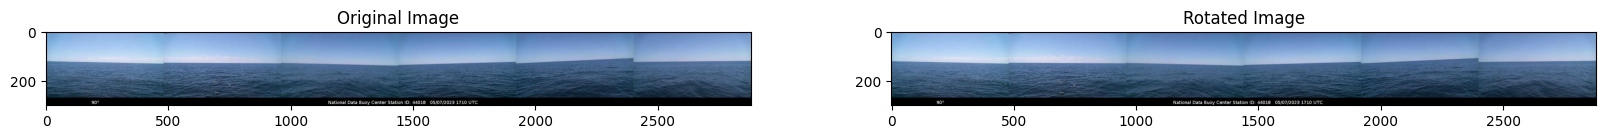

In [44]:
# show results
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(panoramic_image)
ax[0].set_title("Original Image")
ax[1].imshow(panoramic_image.rotate(rotate_line))
ax[1].set_title("Rotated Image")
plt.show()

In [7]:
def rotate_point(point, angle):
    x, y = point
    theta = np.radians(angle)
    new_x = x * np.cos(theta) - y * np.sin(theta)
    new_y = x * np.sin(theta) + y * np.cos(theta)
    return new_x, new_y

In [8]:
def rotate_polygon(polygon, angle):
    """Rotate the given polygon which consists of corners represented as (x,y)
    around center (cx,cy) by angle radians.
    """
    angle = np.deg2rad(angle)
    rotated_polygon = []
    for corner in polygon:
        rotated_corner = rotate_point(corner, angle)
        rotated_polygon.append(rotated_corner)
    return rotated_polygon

fixing panels
adjusting panels
showing panels


/var/folders/ly/b_rl0knd27n_wy81pqqqp8q40000gn/T/ipykernel_89569/2617153604.py:100: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)


ValueError: zero-size array to reduction operation minimum which has no identity

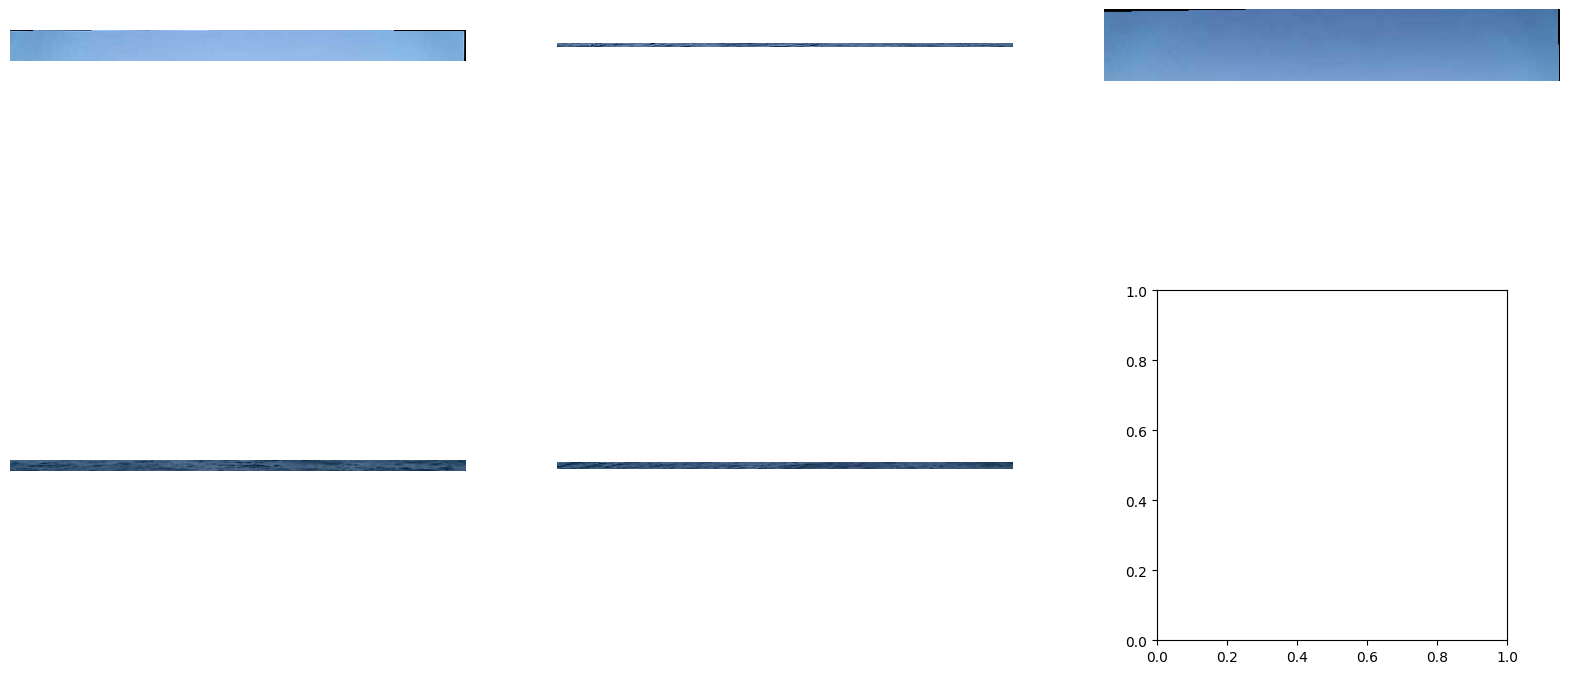

In [40]:
def rotate_polygon(polygon, angle, center):
    angle = np.deg2rad(angle)
    polygon = polygon - center
    rotated_polygon = np.dot(polygon, np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]))
    rotated_polygon = rotated_polygon + center
    return rotated_polygon

def rotate_line(line, angle, center):
    line = line - center
    line = np.dot(line, np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]))
    line = line + center
    return line


def rotate_point(point, angle):
    x, y = point
    theta = np.radians(angle)
    new_x = x * np.cos(theta) - y * np.sin(theta)
    new_y = x * np.sin(theta) + y * np.cos(theta)
    return new_x, new_y
# visualize the colors by making a new image with the average color filled in above the horizon line (at the correct tilt angle) and the average color filled in below the horizon line for the ocean.

fig, ax = plt.subplots(figsize=(20, 10))



# # fix all panels 
# print(f'fixing panels')
# for panel, i in enumerate(cropped_panels):
#     # crop the bottom of the panel to remove the black bar
#     panel = panel.crop((0, 0, panel.width, panel.height - 20))
#     horizon_tilt = detect_horizon_tilt(panel)
#     # rotate the panel to make the horizon line horizontal
#     panel = panel.rotate(horizon_tilt, expand=False,
#                             resample=Image.BICUBIC, center=(panel.width // 2, panel.height // 2)) # expand=True to avoid cropping out parts of the image
#     # draw a line at the horizon
#     width, height = panel.size
#     horizon_line = np.array([(0, height // 2), (width, height // 2)])
#     ax.plot(horizon_line[:, 0], horizon_line[:, 1], color='red')
#     # detect any black pixels at the top and bottom of the image and adjust to crop them out
#     black_pixels = np.where(np.array(panel) == [0, 0, 0])
#     top_black_pixel = np.min(black_pixels[0]) #TODO -- doesn't seem to be finding black pixels
#     bottom_black_pixel = np.max(black_pixels[0])
#     panel = panel.crop((0, top_black_pixel, panel.width, bottom_black_pixel))
#     # save the panel back to the cropped_panels list
#     cropped_panels[i] = panel

# fix all panels
print(f'fixing panels')
for i, panel in enumerate(cropped_panels):
        if panel.height < 20:  # Skip cropping if height is less than 20
        continue
    # crop the bottom of the panel to remove the black bar
    panel = panel.crop((0, 0, panel.width, panel.height - 20))
    horizon_tilt = detect_horizon_tilt(panel)
    # rotate the panel to make the horizon line horizontal
    panel = panel.rotate(horizon_tilt, expand=False,
                            resample=Image.BICUBIC, center=(panel.width // 2, panel.height // 2)) # expand=True to avoid cropping out parts of the image
    # draw a line at the horizon
    width, height = panel.size
    horizon_line = np.array([(0, height // 2), (width, height // 2)])
    ax.plot(horizon_line[:, 0], horizon_line[:, 1], color='red')
    # detect any black pixels at the top and bottom of the image and adjust to crop them out
    grayscale_panel = panel.convert('L')  # convert to grayscale
    threshold = 50  # adjust as necessary
    black_pixels = np.where(np.array(grayscale_panel) < threshold)
    top_black_pixel = np.min(black_pixels[0])
    bottom_black_pixel = np.max(black_pixels[0])
    panel = panel.crop((0, top_black_pixel, panel.width, bottom_black_pixel))
    # save the panel back to the cropped_panels list
    cropped_panels[i] = panel


# adjust all panels
print(f'adjusting panels')
for i, panel in enumerate(cropped_panels):
    if panel.height < 20:  # Skip cropping if height is less than 20
        continue
    panel = panel.crop((0, 0, panel.width, panel.height - 20))
    horizon_tilt = detect_horizon_tilt(panel)
    panel = panel.rotate(horizon_tilt, expand=False,
                            resample=Image.BICUBIC, center=(panel.width // 2, panel.height // 2))
    ...

    # draw a line at the horizon
    width, height = panel.size
    horizon_line = np.array([(0, height // 2), (width, height // 2)])
    ax.plot(horizon_line[:, 0], horizon_line[:, 1], color='red')
    # detect any black pixels at the top and bottom of the image and adjust to crop them out
    black_pixels = np.where(np.array(panel) == [0, 0, 0])
    top_black_pixel = np.min(black_pixels[0])
    bottom_black_pixel = np.max(black_pixels[0])
    panel = panel.crop((0, top_black_pixel, panel.width, bottom_black_pixel))
    # save the panel back to the cropped_panels list
    cropped_panels[i] = panel

# show the panels
print(f'showing panels')
for i, panel in enumerate(cropped_panels):
    plt.subplot(2, 3, i + 1)
    plt.imshow(panel)
    plt.axis('off')
plt.show()